**Dataset Used**

LISC Dataset

download- https://drive.google.com/file/d/16321U5pHl5bKZUvN1p1SIlzRqjdnRfQM/view

In [499]:
# %pip install opencv-python scikit-image scikit-learn scikit-fuzzy tqdm

In [500]:
# %pip install fcmeans

In [501]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.cluster import KMeans
from tqdm import tqdm

In [502]:
image_path = r"LISC Database/Main Dataset/neut/31.bmp"
mask_path  = r"LISC Database/Ground Truth Segmentation/neut/areaforexpert1/31_expert.bmp"

**Checking image and ground mask**

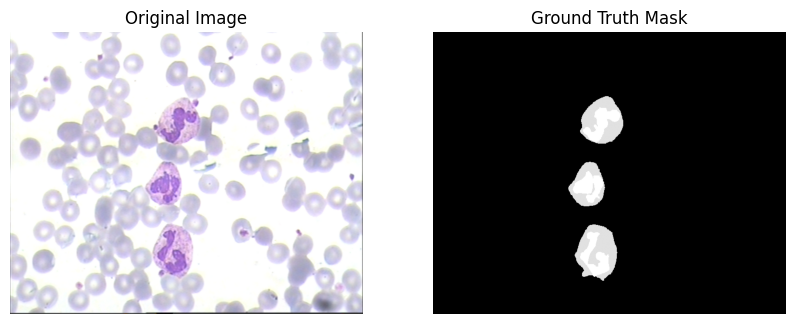

In [503]:
# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load mask (grayscale)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# If size mismatch, fix it
if mask.shape != image.shape[:2]:
    mask = cv2.resize(mask,
                      (image.shape[1], image.shape[0]),
                      interpolation=cv2.INTER_NEAREST)

# ----- Display -----
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()

In [504]:
# ----- Print unique mask values -----
unique_vals = np.unique(mask)
print("Unique mask values:", unique_vals)

Unique mask values: [  0 225 255]


**Dataset Paths**

In [505]:
MAIN_DATASET = "LISC Database/Main Dataset"
GT_DATASET   = "LISC Database/Ground Truth Segmentation"

TEST_FOLDER = "neut"   # Change later when scaling

**Convert mask to multiclass**

In [506]:
def convert_mask_to_multiclass(mask):
    gt = np.zeros_like(mask, dtype=np.uint8)
    unique_vals = np.unique(mask)

    non_zero = sorted(unique_vals[unique_vals > 0])

    if len(non_zero) >= 2:
        cytoplasm_val = non_zero[0]
        nucleus_val   = non_zero[-1]

        gt[mask == cytoplasm_val] = 1
        gt[mask == nucleus_val]   = 2

    return gt

**Resize Mask**

In [507]:
def resize_mask_to_image(mask, image):
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(
            mask,
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST  # VERY IMPORTANT
        )
    return mask

**Preprocessing**

In [508]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab = lab.astype(np.float32) / 255.0
    return lab

**Detect WBC Region**

In [509]:
def get_wbc_mask(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    a_channel = lab[:,:,1]

    _, thresh = cv2.threshold(a_channel, 140, 255, cv2.THRESH_BINARY)

    kernel = np.ones((7,7), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh)

    if num_labels <= 1:
        return np.zeros_like(thresh)

    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    wbc_mask = (labels == largest).astype(np.uint8)

    return wbc_mask

**Apply k-means clustering - hard clustering**

In [510]:
def kmeans_segmentation(image, wbc_mask):
    h, w, c = image.shape
    pixels = image.reshape(-1, c)

    mask_flat = wbc_mask.flatten()
    wbc_pixels = pixels[mask_flat == 1]

    if len(wbc_pixels) == 0:
        return np.zeros((h, w))

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(wbc_pixels)

    full_labels = np.zeros(h*w)
    full_labels[mask_flat == 1] = labels + 1

    return full_labels.reshape(h, w)

**Fuzzy c-means clustering - soft clustering**

In [511]:
def fcm_segmentation(image, wbc_mask):
    h, w, c = image.shape
    pixels = image.reshape(-1, c)

    mask_flat = wbc_mask.flatten()
    wbc_pixels = pixels[mask_flat == 1]

    if len(wbc_pixels) == 0:
        return np.zeros((h, w))

    wbc_pixels = wbc_pixels.T

    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        wbc_pixels,
        c=2,
        m=2,
        error=0.005,
        maxiter=1000
    )

    labels = np.argmax(u, axis=0)

    full_labels = np.zeros(h*w)
    full_labels[mask_flat == 1] = labels + 1

    return full_labels.reshape(h, w)

**align predicted clusters with gt**

In [512]:
def align_clusters(pred, gt):
    aligned = np.zeros_like(pred)

    for cluster_id in np.unique(pred):
        if cluster_id == 0:
            continue

        mask = (pred == cluster_id)
        true_labels = gt[mask]

        if len(true_labels) == 0:
            continue

        majority_label = np.bincount(true_labels).argmax()
        aligned[mask] = majority_label

    return aligned

**Boundary f1 function**

In [513]:
def boundary_f1(gt, pred, class_id):
    gt_bin = (gt == class_id).astype(np.uint8)
    pred_bin = (pred == class_id).astype(np.uint8)

    gt_edges = cv2.Canny(gt_bin * 255, 100, 200)
    pred_edges = cv2.Canny(pred_bin * 255, 100, 200)

    intersection = np.sum((gt_edges > 0) & (pred_edges > 0))

    precision = intersection / (np.sum(pred_edges > 0) + 1e-8)
    recall    = intersection / (np.sum(gt_edges > 0) + 1e-8)

    return (2 * precision * recall) / (precision + recall + 1e-8)

**Dice Score (per class)**

In [514]:
def dice_score(gt, pred, class_id):
    gt_bin = (gt == class_id).astype(np.uint8)
    pred_bin = (pred == class_id).astype(np.uint8)

    intersection = np.sum(gt_bin * pred_bin)
    return (2 * intersection) / (np.sum(gt_bin) + np.sum(pred_bin) + 1e-8)

In [515]:
def colorize_segmentation(seg):
    colored = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

    # Background
    colored[seg == 0] = [0, 0, 0]

    # Cytoplasm
    colored[seg == 1] = [0, 255, 0]

    # Nucleus
    colored[seg == 2] = [255, 0, 0]

    return colored

In [516]:
def visualize_results(image, gt, k_aligned, f_aligned):

    gt_color = colorize_segmentation(gt)
    k_color  = colorize_segmentation(k_aligned)
    f_color  = colorize_segmentation(f_aligned)

    plt.figure(figsize=(16,6))

    plt.subplot(1,4,1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("Ground Truth")
    plt.imshow(gt_color)
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("KMeans (Hard)")
    plt.imshow(k_color)
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("FCM (Soft)")
    plt.imshow(f_color)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

**Run on One Folder**

Processing neut:   2%|▏         | 1/50 [00:00<00:16,  3.03it/s]

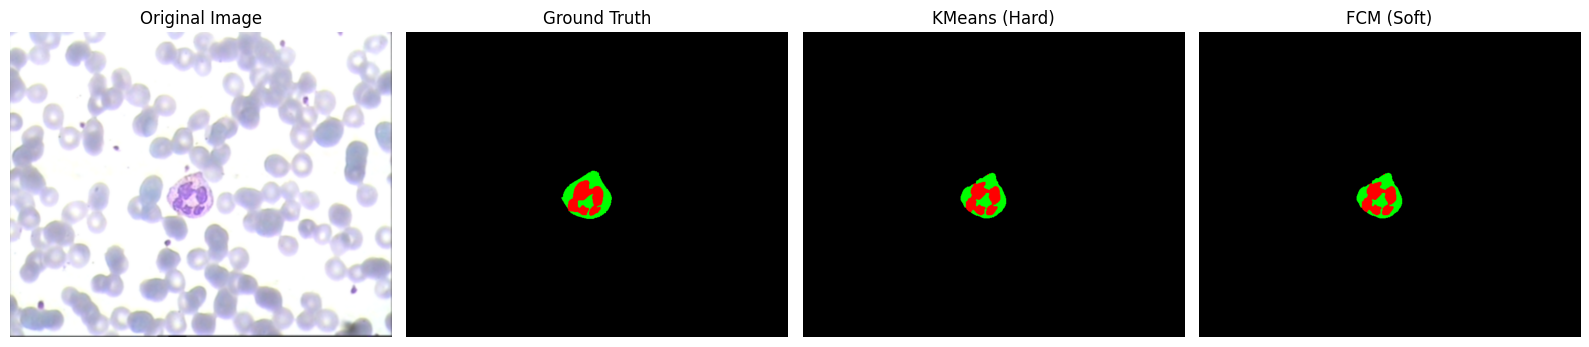

Processing neut: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


In [517]:
image_folder = os.path.join(MAIN_DATASET, TEST_FOLDER)
mask_folder  = os.path.join(GT_DATASET, TEST_FOLDER, "areaforexpert1")

kmeans_dice_scores = []
fcm_dice_scores = []

kmeans_boundary_scores = []
fcm_boundary_scores = []

image_files = [f for f in os.listdir(image_folder) if f.endswith(".bmp")]

for file in tqdm(image_files, desc=f"Processing {TEST_FOLDER}"):

    img_path = os.path.join(image_folder, file)
    mask_path = os.path.join(mask_folder, file.replace(".bmp", "_expert.bmp"))

    if not os.path.exists(mask_path):
        continue
    
    #Load image
    image = cv2.imread(img_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Gaussian smoothing
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    
    #mask operations
    mask = resize_mask_to_image(mask, image)
    gt = convert_mask_to_multiclass(mask)
    
    #preprocess for segmentation
    image_p = preprocess_image(image)

    # WBC detection
    wbc_mask = get_wbc_mask(image)

    # Segment only inside WBC
    k_pred = kmeans_segmentation(image_p, wbc_mask)
    f_pred = fcm_segmentation(image_p, wbc_mask)
    
    #Morphological refinements
    kernel = np.ones((3,3), np.uint8)

    k_pred = cv2.morphologyEx(k_pred.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    k_pred = cv2.morphologyEx(k_pred, cv2.MORPH_CLOSE, kernel)

    f_pred = cv2.morphologyEx(f_pred.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    f_pred = cv2.morphologyEx(f_pred, cv2.MORPH_CLOSE, kernel)    
    
    #align clusters to GT labels
    k_aligned = align_clusters(k_pred, gt)
    f_aligned = align_clusters(f_pred, gt)
    
    #visualization
    if file == image_files[1]:  # visualize only first image
        visualize_results(image, gt, k_aligned, f_aligned)
    
    #evaluation
    for class_id in [1,2]:
        kmeans_dice_scores.append(dice_score(gt, k_aligned, class_id))
        fcm_dice_scores.append(dice_score(gt, f_aligned, class_id))

        kmeans_boundary_scores.append(boundary_f1(gt, k_aligned, class_id))
        fcm_boundary_scores.append(boundary_f1(gt, f_aligned, class_id))

**Final Results**

In [518]:
print("\n===== FINAL RESULTS =====")

print("\nAverage Dice:")
print("KMeans:", np.mean(kmeans_dice_scores))
print("FCM:", np.mean(fcm_dice_scores))

print("\nAverage Boundary F1:")
print("KMeans:", np.mean(kmeans_boundary_scores))
print("FCM:", np.mean(fcm_boundary_scores))


===== FINAL RESULTS =====

Average Dice:
KMeans: 0.8145237247854041
FCM: 0.8147161936588714

Average Boundary F1:
KMeans: 0.17270382275390422
FCM: 0.17328501448939115
